In [35]:
!pip install ipdb

In [36]:
!pip install torchmetrics

In [37]:
import pandas as pd
import numpy as np
from string import punctuation
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from torch.nn.utils.rnn import pad_sequence
import torch.optim as optim
import ipdb
import gensim
import matplotlib.pyplot as plt
import re
from gensim.models import FastText
from torchmetrics.functional import f1, recall

#Dataset1

In [38]:
'''!wget -O positive.csv https://www.dropbox.com/s/fnpq3z4bcnoktiv/positive.csv?dl=0
!wget -O negative.csv https://www.dropbox.com/s/r6u59ljhhjdg6j0/negative.csv?dl=0'''

'!wget -O positive.csv https://www.dropbox.com/s/fnpq3z4bcnoktiv/positive.csv?dl=0\n!wget -O negative.csv https://www.dropbox.com/s/r6u59ljhhjdg6j0/negative.csv?dl=0'

In [79]:
pos_tweets = pd.read_csv('positive.csv', encoding='utf-8', sep=';', header=None,  names=[0,1,2,'text','tone',5,6,7,8,9,10,11])

In [80]:
neg_tweets = pd.read_csv('negative.csv', encoding='utf-8', sep=';', header=None, names=[0,1,2,'text','tone',5,6,7,8,9,10,11] )
neg_tweets['tone'] = 0

In [81]:
all_tweets_data = pos_tweets.append(neg_tweets)
print(len(all_tweets_data))

226834


In [82]:
tweets_data = shuffle(all_tweets_data[['text','tone']])[:100000]

In [83]:
def preprocess(text):
      text = text.lower().replace("ё", "е")
      text = re.sub('((www\.[^\s]+)|(https?://[^\s]+))', 'URL', text)
      text = re.sub('@[^\s]+', 'USER', text)
      text = re.sub('[^a-zA-Zа-яА-Я1-9]+', ' ', text)
      text = re.sub(' +', ' ', text)
      return text.strip()

In [84]:
clean_text = tweets_data['text'].apply(preprocess)
tweets_data['clean_text'] = clean_text

In [85]:
train_sentences, val_sentences = train_test_split(tweets_data, test_size=0.1)
train_sentences

,text,tone,clean_text
99397,OPEN PACK 1 000 000 COINS!!! R172184516292 - с...,0,open pack 1 coins r172184516292 сбор бомжу на ...
89784,"Вытощили меня из дому, так не хотела идти((",0,вытощили меня из дому так не хотела идти
109488,RT @BureevaMarina: - Хотела отложить денег на ...,1,rt USER хотела отложить денег на старость не п...
98153,RT @lentaruofficial: План выступления такой: 1...,1,rt USER план выступления такой 1 социалочка на...
37953,@5tv_news А зачем Вы прерывались на рекламу то...,0,USER а зачем вы прерывались на рекламу то он п...
...,...,...,...
19958,"@Chynara_B еще как! Ну что, чувствуешь себя ме...",1,USER еще как ну что чувствуешь себя менее эгои...
89455,"обажаю Арию) и я не о музыкантах, а о девочке ...",1,обажаю арию и я не о музыкантах а о девочке из...
20770,"какая ""классная"" эта пятница 13-ое(( голова уж...",0,какая классная эта пятница 13 ое голова уже по...
3382,@KovalenkoIgor В Украине ее видать внимательно...,1,USER в украине ее видать внимательно читали


In [86]:
vocab = Counter()

for text in tweets_data['clean_text']:
    vocab.update(preprocess(text).split())
print('всего уникальных токенов:', len(vocab))

всего уникальных токенов: 111486


In [87]:
filtered_vocab = set()

for word in vocab:
    if vocab[word] > 2:
        filtered_vocab.add(word)
print('уникальных токенов, втретившихся больше 2 раз:', len(filtered_vocab))

уникальных токенов, втретившихся больше 2 раз: 29074


In [88]:
#создаем словарь с индексами word2id, для спецсимвола паддинга дефолтный индекс - 0
word2id = {'PAD':0}

for word in filtered_vocab:
    word2id[word] = len(word2id)

In [89]:
#обратный словарь для того, чтобы раскодировать последовательность
id2word = {i:word for word, i in word2id.items()}

In [90]:
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
DEVICE

device(type='cuda')

In [91]:
class TweetsDataset(Dataset):

    def __init__(self, dataset, word2id, DEVICE):
        self.dataset = dataset['text'].values
        self.word2id = word2id
        self.length = dataset.shape[0]
        self.target = dataset['tone'].values
        self.device = DEVICE

    def __len__(self): #это обязательный метод, он должен уметь считать длину датасета
        return self.length

    def __getitem__(self, index): #еще один обязательный метод. По индексу возвращает элемент выборки
        tokens = self.preprocess(self.dataset[index]) # токенизируем
        ids = torch.LongTensor([self.word2id[token] for token in tokens if token in self.word2id])
        y = [self.target[index]]
        return ids, y
    
    def preprocess(self, text):
      text = text.lower().replace("ё", "е")
      text = re.sub('((www\.[^\s]+)|(https?://[^\s]+))', 'URL', text)
      text = re.sub('@[^\s]+', 'USER', text)
      text = re.sub('[^a-zA-Zа-яА-Я1-9]+', ' ', text)
      text = re.sub(' +', ' ', text)
      return text.strip()

    def collate_fn(self, batch): #этот метод можно реализовывать и отдельно,
    # он понадобится для DataLoader во время итерации по батчам
      ids, y = list(zip(*batch))
      padded_ids = pad_sequence(ids, batch_first=True).to(self.device)
      #мы хотим применять BCELoss, он будет брать на вход predicted размера batch_size x 1 (так как для каждого семпла модель будет отдавать одно число), target размера batch_size x 1
      y = torch.Tensor(y).to(self.device) # tuple ([1], [0], [1])  -> Tensor [[1.], [0.], [1.]] 
      return padded_ids, y

In [92]:
train_dataset = TweetsDataset(train_sentences, word2id, DEVICE)
train_sampler = RandomSampler(train_dataset)
train_iterator = DataLoader(train_dataset, collate_fn = train_dataset.collate_fn, sampler=train_sampler, batch_size=1024)

In [93]:
val_dataset = TweetsDataset(val_sentences, word2id, DEVICE)
val_sampler = SequentialSampler(val_dataset)
val_iterator = DataLoader(val_dataset, collate_fn = val_dataset.collate_fn, sampler=val_sampler, batch_size=1024)

In [94]:
ft = FastText(tweets_data['clean_text'].tolist(), size=100, window=5, min_count=1)

In [95]:
weights = np.zeros((len(word2id), 100))
count = 0
for word, i in word2id.items():
    if word == 'PAD':
        continue   
    try:
        weights[i] = ft.wv[word]    
    except KeyError:
      count += 1
      # oov словам сопоставляем случайный вектор
      weights[i] = np.random.normal(0,0.1,100)

In [96]:
class CNN(nn.Module):
    
    def __init__(self, vocab_size, embedding_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.embedding.from_pretrained(torch.tensor(weights), freeze=True)

        self.bigrams = nn.Conv1d(in_channels=embedding_dim, out_channels=100, kernel_size=2, padding='same')
        self.trigrams = nn.Conv1d(in_channels=embedding_dim, out_channels=80, kernel_size=3, padding='same')
        self.bigrams2 = nn.Conv1d(in_channels=180, out_channels=180, kernel_size=2, padding='same')

        self.pooling = nn.MaxPool1d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()
        self.hidden = nn.Linear(in_features=180, out_features=1)
        self.out = nn.Sigmoid()

    def forward(self, word):
        #batch_size x seq_len
        embedded = self.embedding(word)
        #batch_size x seq_len x embedding_dim
        embedded = embedded.transpose(1,2)
        #batch_size x embedding_dim x seq_len
        feature_map_bigrams = self.relu(self.bigrams(embedded))
        #batch_size x filter_count2 x seq_len* 
        feature_map_trigrams = self.relu(self.trigrams(embedded))
        #batch_size x filter_count3 x seq_len*

        concat = torch.cat((feature_map_bigrams, feature_map_trigrams), 1)
        bigrams = self.pooling(self.relu(self.bigrams2(concat)))
        pooling = bigrams.max(2)[0] 
        # batch _size x (filter_count2 + filter_count3)

        logits = self.hidden(pooling) 
        logits = self.out(logits)      
        return logits

In [97]:
def train(model, iterator, optimizer, criterion):
    epoch_loss = 0 # для подсчета среднего лосса на всех батчах

    model.train()  # ставим модель в обучение, явно указываем, что сейчас надо будет хранить градиенты у всех весов

    for i, (texts, ys) in enumerate(iterator): #итерируемся по батчам
        optimizer.zero_grad()  #обнуляем градиенты
        preds = model(texts)  #прогоняем данные через модель
        loss = criterion(preds, ys) #считаем значение функции потерь  
        loss.backward() #считаем градиенты  
        optimizer.step() #обновляем веса 
        epoch_loss += loss.item() #сохраняем значение функции потерь
        if not (i + 1) % int(len(iterator)/5):
            print(f'Train loss: {epoch_loss/i}')      
    return  epoch_loss / len(iterator) # возвращаем среднее значение лосса по всей выборке

In [98]:
def evaluate(model, iterator, criterion):
    epoch_loss = 0
    epoch_metric = 0
    model.eval() 
    with torch.no_grad():
        for i, (texts, ys) in enumerate(iterator):   
            preds = model(texts)  # делаем предсказания на тесте
            loss = criterion(preds, ys)   # считаем значения функции ошибки для статистики  
            epoch_loss += loss.item()
            batch_metric = f1(preds.round().long(), ys.long(), ignore_index=0)
            epoch_metric += batch_metric

            if not (i + 1) % int(len(iterator)/5):
              print(f'Val loss: {epoch_loss/i}, Val f1: {epoch_metric/i}')
        
    return epoch_metric / len(iterator), epoch_loss / len(iterator) # возвращаем среднее значение по всей выборке

In [99]:
def predict(model, iterator):
    preds = []
    model.eval()
    with torch.no_grad():
        for i, (words, ys) in enumerate(iterator): 
            for word in model(words):
                preds.append(word.cpu().detach().numpy().round())
    return preds

In [100]:
model = CNN(len(word2id), 2)
optimizer = optim.Adam(model.parameters(), lr=0.0005)
criterion = nn.BCELoss()  

# веса модели и значения лосса храним там же, где и все остальные тензоры
model = model.to(DEVICE)
criterion = criterion.to(DEVICE)

In [101]:
losses = []
losses_eval = []
f1s = []
f1s_eval = []

for i in range(20):
    print(f'\nstarting Epoch {i}')
    print('Training...')
    epoch_loss = train(model, train_iterator, optimizer, criterion)
    losses.append(epoch_loss)
    print('\nEvaluating on train...')
    f1_on_train,_ = evaluate(model, train_iterator, criterion)
    f1s.append(f1_on_train)
    print('\nEvaluating on test...')
    f1_on_test, epoch_loss_on_test = evaluate(model, val_iterator, criterion)
    losses_eval.append(epoch_loss_on_test)
    f1s_eval.append(f1_on_test)


starting Epoch 0
Training...
Train loss: 0.735472496598959
Train loss: 0.7095405712272181
Train loss: 0.7002316045761109
Train loss: 0.6947283059803407
Train loss: 0.6913344640107382

Evaluating on train...
Val loss: 0.714620940387249, Val f1: 0.6434759497642517
Val loss: 0.6927909598206029, Val f1: 0.6230840086936951
Val loss: 0.6863144278526306, Val f1: 0.6149309873580933
Val loss: 0.6827635702802174, Val f1: 0.6135111451148987
Val loss: 0.680903964809009, Val f1: 0.6111968755722046

Evaluating on test...
Val loss: 1.351104736328125, Val f1: 1.2278809547424316
Val loss: 0.8975805640220642, Val f1: 0.8272130489349365
Val loss: 0.8083777785301208, Val f1: 0.7333551645278931
Val loss: 0.7702023472104754, Val f1: 0.69706130027771
Val loss: 0.7480032642682394, Val f1: 0.6762056946754456

starting Epoch 1
Training...
Train loss: 0.7149573117494583
Train loss: 0.6912631952401364
Train loss: 0.6827675044536591
Train loss: 0.6788813703095735
Train loss: 0.6755706405355817

Evaluating on trai

No handles with labels found to put in legend.


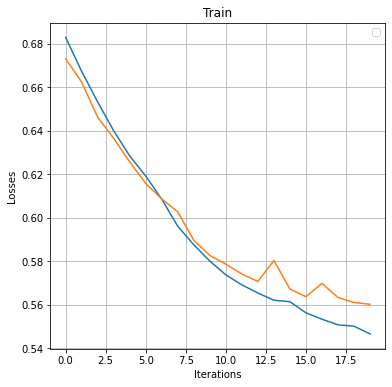

In [102]:
fig, ax = plt.subplots(figsize=(6, 6))
plt.title('Train')
plt.xlabel('Iterations')
plt.ylabel('Losses')
plt.grid()
ax.plot(losses)
ax.plot(losses_eval)
ax.legend()
plt.show()

In [103]:
losses[-1]

0.546547457575798

In [104]:
losses_eval[-1]

0.5601945519447327

In [105]:
f1s[-1]

tensor(0.7003, device='cuda:0')

In [106]:
f1s_eval[-1]

tensor(0.6872, device='cuda:0')

In [107]:
val_sentences['predicted']  = predict(model, val_iterator)

In [108]:
# TP
val_sentences[(val_sentences['tone'] == 1) & (val_sentences['predicted'] == 1)]['clean_text'].to_list()[:10]

['здоровски погуляли по магазинам с USER пингвины',
 'прикольно когда к тебе в бар приходит девушка выпить кофе на мин 1 15 а в итоге зависает у тебя в баре на хороших часа полтора',
 'USER не умирай еще тебе предстоит вечер',
 'rt USER юмор красота требует жертв придумай смешную подпись к картинке URL',
 'давайте уж побыстрее 12 декабря объявляйте выходным днем и переносите на пятницу 13 буду строить планы',
 'USER холодно очень и паскаль делает мне страдай d',
 'время сна я утомилась дико завтра сложный день 6 5 часов мне на восстановление сил всем доброй ночи',
 'USER смешно ему и плюс мне масса нужна в спорте немного я как бить буду если сил нету крч диета для идиотов',
 'USER норм вообще то мы на наших ярмарках вообще мало зарабатываем',
 'USER USER если ты затусишь после у сережи тебе вообще супер удобно будет']

In [109]:
# FN
val_sentences[(val_sentences['tone'] == 1) & (val_sentences['predicted'] == 0)]['clean_text'].to_list()[:10]

['ник вернется в сериал полиция гавайев счастьерадость ну правильно а то закончили на самом интересном',
 'USER ну у меня времени много могу поиграть в шерлока но лучше скажи',
 'USER иногда хочется тебя ретвитить но функция недоступна',
 'USER USER законная власть должна в ес вступать а не рот свой открывать вот что главно',
 'USER 27 2 7 в 7 лет в крепости у весного огня почетный караул ебнулся чтоли',
 'я только недавно хотела зимы теперь хочу лета а у лета я буду просить зимы',
 'на улице очень весело но очень холодно выбор между сугробом и домом не так то прост на самом деле',
 'USER ну я пока еще с тюленем не танцевала',
 'USER я родилась на украине но еще в детстве переехали с мамой в россию ты из какого города',
 'USER USER да чего там две дырки проделать для рук и все х']

In [110]:
# FP
val_sentences[(val_sentences['tone'] == 0) & (val_sentences['predicted'] == 1)]['clean_text'].to_list()[:10]

['USER ну я всегда говорил что я тп',
 'USER дина ты дура чтоли о о заткнись чтоли о о',
 'rt USER епт так ты баба нет кто тебе сказал такую глупость у меня есть пипирка URL',
 'если я его потеряю я этого просто не переживу',
 'рано утром снова кровь сдавать снова не позавтракаю',
 'rt USER есть у кого нибудь наушники кому не жалко дайте мне',
 'USER USER сегодня последний день и больше в этом году мы не увидим наших любимых мальчиков до самой осени',
 'а у мну не работает рекомендация с комментами вторая попытка и фейл чяднт',
 'сразу ощущается разница между журналистами иностранными и нашими путинотвечает',
 'USER я так и не посмотрела фильм мне пришлось срочно уйти']

TP: здесь в основном содержатся положительные высказывания

FN: здесь в основном содержатс шуточные высказывания

FP: можно заметить, что тут находятся высказывания, содержащие в основном негативный контекст, а также частица *не*

#Улучшение

In [111]:
train_dataset = TweetsDataset(train_sentences, word2id, DEVICE)
train_sampler = RandomSampler(train_dataset)
train_iterator = DataLoader(train_dataset, collate_fn = train_dataset.collate_fn, sampler=train_sampler, batch_size=1024)

In [112]:
val_dataset = TweetsDataset(val_sentences, word2id, DEVICE)
val_sampler = SequentialSampler(val_dataset)
val_iterator = DataLoader(val_dataset, collate_fn = val_dataset.collate_fn, sampler=val_sampler, batch_size=1024)

In [113]:
class BetterCNN(nn.Module):
    
    def __init__(self, vocab_size, embedding_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.embedding.from_pretrained(torch.tensor(weights), freeze=True)

        self.bigrams = nn.Conv1d(in_channels=embedding_dim, out_channels=100, kernel_size=2, padding='same')
        self.trigrams = nn.Conv1d(in_channels=embedding_dim, out_channels=80, kernel_size=3, padding='same')
        self.bigrams_over = nn.Conv1d(in_channels=180, out_channels=180, kernel_size=2, padding='same')

        self.pooling = nn.MaxPool1d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()
        self.hidden = nn.Linear(in_features=180, out_features=1)
        self.dropout = nn.Dropout(p=0.5)
        self.out = nn.Sigmoid()

    def forward(self, word):
        #batch_size x seq_len
        embedded = self.embedding(word)
        #batch_size x seq_len x embedding_dim
        embedded = embedded.transpose(1,2)
        #batch_size x embedding_dim x seq_len
        feature_map_bigrams = self.relu(self.bigrams(embedded))
        #batch_size x filter_count2 x seq_len* 
        feature_map_trigrams = self.relu(self.trigrams(embedded))
        #batch_size x filter_count3 x seq_len*

        concat = torch.cat((feature_map_bigrams, feature_map_trigrams), 1)
        bigrams = self.dropout(self.pooling(self.relu(self.bigrams_over(concat))))
        pooling = bigrams.max(2)[0] 
        # batch _size x (filter_count2 + filter_count3)

        logits = self.hidden(pooling)
        logits = self.out(logits)      
        return logits

In [114]:
def train(model, iterator, optimizer, criterion):
    epoch_loss = 0 # для подсчета среднего лосса на всех батчах

    model.train()  # ставим модель в обучение, явно указываем, что сейчас надо будет хранить градиенты у всех весов

    for i, (texts, ys) in enumerate(iterator): #итерируемся по батчам
        optimizer.zero_grad()  #обнуляем градиенты
        preds = model(texts)  #прогоняем данные через модель
        loss = criterion(preds, ys) #считаем значение функции потерь  
        loss.backward() #считаем градиенты  
        optimizer.step() #обновляем веса 
        epoch_loss += loss.item() #сохраняем значение функции потерь
        if not (i + 1) % int(len(iterator)/5):
            print(f'Train loss: {epoch_loss/i}')      
    return  epoch_loss / len(iterator) # возвращаем среднее значение лосса по всей выборке

In [115]:
def evaluate(model, iterator, criterion):
    epoch_loss = 0
    epoch_metric = 0
    model.eval() 
    with torch.no_grad():
        for i, (texts, ys) in enumerate(iterator):   
            preds = model(texts)  # делаем предсказания на тесте
            loss = criterion(preds, ys)   # считаем значения функции ошибки для статистики  
            epoch_loss += loss.item()
            batch_metric = f1(preds.round().long(), ys.long(), ignore_index=0)
            epoch_metric += batch_metric

            if not (i + 1) % int(len(iterator)/5):
              print(f'Val loss: {epoch_loss/i}, Val f1: {epoch_metric/i}')
        
    return epoch_metric / len(iterator), epoch_loss / len(iterator) # возвращаем среднее значение по всей выборке

In [116]:
model = BetterCNN(len(word2id), 10)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
criterion = nn.BCELoss()  

# веса модели и значения лосса храним там же, где и все остальные тензоры
model = model.to(DEVICE)
criterion = criterion.to(DEVICE)

In [117]:
losses = []
losses_eval = []
f1s = []
f1s_eval = []

for i in range(20):
    print(f'\nstarting Epoch {i}')
    print('Training...')
    epoch_loss = train(model, train_iterator, optimizer, criterion)
    losses.append(epoch_loss)
    print('\nEvaluating on train...')
    f1_on_train,_ = evaluate(model, train_iterator, criterion)
    f1s.append(f1_on_train)
    print('\nEvaluating on test...')
    f1_on_test, epoch_loss_on_test = evaluate(model, val_iterator, criterion)
    losses_eval.append(epoch_loss_on_test)
    f1s_eval.append(f1_on_test)


starting Epoch 0
Training...
Train loss: 0.7568571642041206
Train loss: 0.7144657030250087
Train loss: 0.6943663966655731
Train loss: 0.6793940796780942
Train loss: 0.6678465831847418

Evaluating on train...
Val loss: 0.6615765579044819, Val f1: 0.7023764252662659
Val loss: 0.6430198658596386, Val f1: 0.6805157661437988
Val loss: 0.6372658371925354, Val f1: 0.6724695563316345
Val loss: 0.6342689012413594, Val f1: 0.6674272418022156
Val loss: 0.6324084230831691, Val f1: 0.6657857298851013

Evaluating on test...
Val loss: 1.242378294467926, Val f1: 1.3243322372436523
Val loss: 0.8301623662312826, Val f1: 0.8778156638145447
Val loss: 0.7492467164993286, Val f1: 0.7868083119392395
Val loss: 0.7146236300468445, Val f1: 0.7527580857276917
Val loss: 0.6949897011121114, Val f1: 0.7273690104484558

starting Epoch 1
Training...
Train loss: 0.6520518027245998
Train loss: 0.6283752069328771
Train loss: 0.6211705350875855
Train loss: 0.6168573178462128
Train loss: 0.613216431367965

Evaluating on 

No handles with labels found to put in legend.


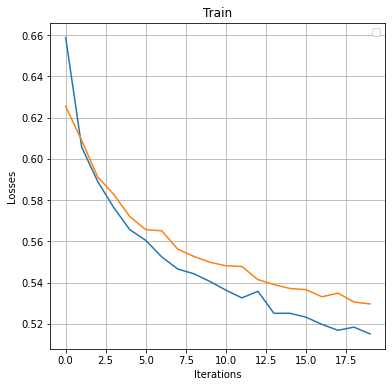

In [118]:
fig, ax = plt.subplots(figsize=(6, 6))
plt.title('Train')
plt.xlabel('Iterations')
plt.ylabel('Losses')
plt.grid()
ax.plot(losses)
ax.plot(losses_eval)
ax.legend()
plt.show()

In [119]:
losses[-1]

0.5150239359248768

In [120]:
losses_eval[-1]

0.5296105921268464

In [121]:
f1s[-1]

tensor(0.7577, device='cuda:0')

In [122]:
f1s_eval[-1]

tensor(0.7408, device='cuda:0')

In [123]:
val_sentences['predicted']  = predict(model, val_iterator)

In [124]:
# TP
val_sentences[(val_sentences['tone'] == 1) & (val_sentences['predicted'] == 1)]['clean_text'].to_list()[:10]

['здоровски погуляли по магазинам с USER пингвины',
 'прикольно когда к тебе в бар приходит девушка выпить кофе на мин 1 15 а в итоге зависает у тебя в баре на хороших часа полтора',
 'USER не умирай еще тебе предстоит вечер',
 'rt USER юмор красота требует жертв придумай смешную подпись к картинке URL',
 'давайте уж побыстрее 12 декабря объявляйте выходным днем и переносите на пятницу 13 буду строить планы',
 'USER холодно очень и паскаль делает мне страдай d',
 'время сна я утомилась дико завтра сложный день 6 5 часов мне на восстановление сил всем доброй ночи',
 'ник вернется в сериал полиция гавайев счастьерадость ну правильно а то закончили на самом интересном',
 'USER смешно ему и плюс мне масса нужна в спорте немного я как бить буду если сил нету крч диета для идиотов',
 'USER иногда хочется тебя ретвитить но функция недоступна']

In [125]:
# FN
val_sentences[(val_sentences['tone'] == 1) & (val_sentences['predicted'] == 0)]['clean_text'].to_list()[:10]

['USER ну у меня времени много могу поиграть в шерлока но лучше скажи',
 'я только недавно хотела зимы теперь хочу лета а у лета я буду просить зимы',
 'на улице очень весело но очень холодно выбор между сугробом и домом не так то прост на самом деле',
 'найти и не потерять муз и сл с филиппов новая песня написанная мной для USER URL',
 'USER USER другим не стыдно другим все равно',
 'блин аж н як забути цього не можу да не хочу боже так мило',
 'USER сломался он не знаю от чего но когда на него звонишь он говорит тебе бай бай так я теперь чика со старым телефоном',
 'сука позавчера отвалился скан у одного ricoh вчера у второго и вот наконец у третьего последнего компания принтеров решила бухнуть',
 'хочу чтобы в этот новый год у меня дома собрались мои родственники',
 'как быстро время идет неделю не заметила URL']

In [126]:
# FP
val_sentences[(val_sentences['tone'] == 0) & (val_sentences['predicted'] == 1)]['clean_text'].to_list()[:10]

['USER ну я всегда говорил что я тп',
 'кто нибудь зайдите вк USER USER USER',
 'четвертый курс кошмар научная статья сюжет федеральные тесты сессии диплом его защита госы и чертовы рейтинги',
 'что то много людей сейчас болеют выздоравливайте зайки',
 'USER каждый одинок по своему',
 'пошел я приберусь а то мама кричать будет',
 'rt USER обновление твиттера крутое а контакта не очень',
 'во мне две половины разрывается между желанием рожать детей и желанием жрать лсд и нюхать кокс с 37сантиметрового члена',
 'USER он выдает мне вирусные сцылки',
 'а у мну не работает рекомендация с комментами вторая попытка и фейл чяднт']

TP:  'ник вернется в сериал полиция гавайев счастьерадость ну правильно а то закончили на самом интересном' попало из FN сюда, наверное из-за *счастьерадость*, еще в конце немного поменялось, но в уелом почти то же самое, хотя и точность не сильно выросла

FN: список стал поменьше, но в целом почти то же самое

FP: а вот тут немного поменялось

#Результаты

При добавлении Dropout равного 0.5, weight_decay равного 1e-4, смене learning rate с 0.0005 на 0.001 результат поменялся в лучшую сторону!

#Dataset2

In [127]:
symbol_vocab = Counter()

for text in tweets_data['clean_text']:
    symbol_vocab.update(list(text))
print('всего уникальных символов:', len(symbol_vocab))

всего уникальных символов: 73


In [128]:
symbol2id = {'PAD':0}

for symbol in symbol_vocab:
    symbol2id[symbol] = len(symbol2id)

id2symbol = {i:symbol for symbol, i in symbol2id.items()}

In [129]:
class WordSymbDataset(Dataset):

    def __init__(self, dataset, word2id, symbol2id, DEVICE):
        self.dataset = dataset['clean_text'].values
        self.word2id = word2id
        self.symbol2id = symbol2id
        self.length = dataset.shape[0]
        self.target = torch.Tensor(dataset['tone'].values)
        self.device = DEVICE

    def __len__(self): #это обязательный метод, он должен уметь считать длину датасета
        return self.length

    def __getitem__(self, index): #еще один обязательный метод. По индексу возвращает элемент выборки
        tokens = self.dataset[index].split() # токенизируем
        word_ids = torch.LongTensor([self.word2id[token] for token in tokens if token in self.word2id])
        symbols = list(self.dataset[index])
        symb_ids = torch.LongTensor([self.symbol2id[symbol] for symbol in symbols if symbol in self.symbol2id])
        y = [self.target[index]]
        return word_ids, symb_ids, y

    def collate_fn(self, batch): #этот метод можно реализовывать и отдельно,
    # он понадобится для DataLoader во время итерации по батчам
      word_ids, symb_ids, y = list(zip(*batch))
      padded_words = pad_sequence(word_ids, batch_first=True).to(self.device)
      padded_symbs = pad_sequence(symb_ids, batch_first=True).to(self.device)
      #мы хотим применять BCELoss, он будет брать на вход predicted размера batch_size x 1 (так как для каждого семпла модель будет отдавать одно число), target размера batch_size x 1
      y = torch.Tensor(y).to(self.device) # tuple ([1], [0], [1])  -> Tensor [[1.], [0.], [1.]] 
      return padded_words, padded_symbs, y

In [130]:
train_dataset = WordSymbDataset(train_sentences, word2id, symbol2id, DEVICE)
train_sampler = RandomSampler(train_dataset)
train_iterator = DataLoader(train_dataset, collate_fn = train_dataset.collate_fn, sampler=train_sampler, batch_size=1024)

In [131]:
val_dataset = WordSymbDataset(val_sentences, word2id, symbol2id, DEVICE)
val_sampler = SequentialSampler(val_dataset)
val_iterator = DataLoader(val_dataset, collate_fn = val_dataset.collate_fn, sampler=val_sampler, batch_size=1024)

In [132]:
class WordSymbCNN(nn.Module):
    def __init__(self, symb_vocab_size, symb_embedding_dim, word_vocab_size):
        super().__init__()
        self.word_embedding = nn.Embedding(word_vocab_size, 100)
        self.word_embedding.from_pretrained(torch.tensor(weights), freeze=True)
        self.word_hidden = nn.Linear(100, 100) 

        self.symb_embedding = nn.Embedding(symb_vocab_size, symb_embedding_dim)
        self.symb_bigrams = nn.Conv1d(in_channels=symb_embedding_dim, out_channels=100, kernel_size=2, padding='same')
        self.symb_trigrams = nn.Conv1d(in_channels=symb_embedding_dim, out_channels=80, kernel_size=3, padding='same')
        self.symb_pooling = nn.MaxPool1d(kernel_size=2, stride=2)
        self.symb_hidden = nn.Linear(in_features=180, out_features=100)
        
        self.linear = nn.Linear(in_features=200, out_features=1)
        self.dropout = nn.Dropout(p=0.5)
        self.relu = nn.ReLU()   
        self.out = nn.Sigmoid()


    def forward(self, words_seq, symb_seq):
        #batch_size x seq_len
        embedded = self.symb_embedding(symb_seq)
        #batch_size x seq_len x embedding_dim
        embedded = embedded.transpose(1,2)
        #batch_size x embedding_dim x seq_len
        feature_map_bigrams = self.dropout(self.symb_pooling(self.relu(self.symb_bigrams(embedded))))
        #batch_size x filter_count2 x seq_len* 
        feature_map_trigrams = self.dropout(self.symb_pooling(self.relu(self.symb_trigrams(embedded))))
        #batch_size x filter_count3 x seq_len*

        pooling1 = feature_map_bigrams.max(2)[0] 
        # batch_size x filter_count2
        pooling2 = feature_map_trigrams.max(2)[0]
        # batch_size x filter_count3
        concat = torch.cat((pooling1, pooling2), 1)
        # batch_size x (filter_count2 + filter_count3)
        symb_vec = self.symb_hidden(concat)

        embedded_words = self.word_embedding(words_seq)   # переводим последовательность индексов в последовательность эмбеддингов
        mean_emb_words = torch.mean(embedded_words, dim=1) # считаем средний эмбеддинг предложения
        word_vec = self.dropout(self.word_hidden(mean_emb_words)) # пропускаем эмбеддинг через полносвязный слой 
        word_vec = self.dropout(self.relu(word_vec))
        concat = torch.cat((symb_vec, word_vec), 1)
        logits = self.out(self.linear(concat))      
        return logits

In [133]:
def train(model, iterator, optimizer, criterion):
    epoch_loss = 0 # для подсчета среднего лосса на всех батчах

    model.train()  # ставим модель в обучение, явно указываем, что сейчас надо будет хранить градиенты у всех весов

    for i, (texts, symbols, ys) in enumerate(iterator): #итерируемся по батчам
        optimizer.zero_grad()  #обнуляем градиенты
        preds = model(texts, symbols)  #прогоняем данные через модель
        loss = criterion(preds, ys) #считаем значение функции потерь  
        loss.backward() #считаем градиенты  
        optimizer.step() #обновляем веса 
        epoch_loss += loss.item() #сохраняем значение функции потерь
        if not (i + 1) % int(len(iterator)/5):
            print(f'Train loss: {epoch_loss/i}')      
    return  epoch_loss / len(iterator) # возвращаем среднее значение лосса по всей выборке

In [134]:
def evaluate(model, iterator, criterion):
    epoch_loss = 0
    epoch_metric = 0
    model.eval() 
    with torch.no_grad():
        for i, (texts, symbols, ys) in enumerate(iterator):   
            preds = model(texts, symbols)  # делаем предсказания на тесте
            loss = criterion(preds, ys)   # считаем значения функции ошибки для статистики  
            epoch_loss += loss.item()
            batch_metric = f1(preds.round().long(), ys.long(), ignore_index=0)
            epoch_metric += batch_metric

            if not (i + 1) % int(len(iterator)/5):
              print(f'Val loss: {epoch_loss/i}, Val f1: {epoch_metric/i}')
        
    return epoch_metric / len(iterator), epoch_loss / len(iterator) # возвращаем среднее значение по всей выборке

In [144]:
def predict_word_symbol(model, iterator):
    preds = []
    model.eval()
    with torch.no_grad():
        for i, (words, symbols, ys) in enumerate(iterator): 
            for word in model(words, symbols):
                preds.append(word.cpu().detach().numpy().round())  # делаем предсказания на тесте 
    return preds

In [135]:
model = WordSymbCNN(len(symbol2id), 10, len(word2id))
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss()  

# веса модели и значения лосса храним там же, где и все остальные тензоры
model = model.to(DEVICE)
criterion = criterion.to(DEVICE)

In [136]:
losses = []
losses_eval = []
f1s = []
f1s_eval = []

for i in range(20):
    print(f'\nstarting Epoch {i}')
    print('Training...')
    epoch_loss = train(model, train_iterator, optimizer, criterion)
    losses.append(epoch_loss)
    print('\nEvaluating on train...')
    f1_on_train,_ = evaluate(model, train_iterator, criterion)
    f1s.append(f1_on_train)
    print('\nEvaluating on test...')
    f1_on_test, epoch_loss_on_test = evaluate(model, val_iterator, criterion)
    losses_eval.append(epoch_loss_on_test)
    f1s_eval.append(f1_on_test)


starting Epoch 0
Training...
Train loss: 0.783716194331646
Train loss: 0.7341999881195299
Train loss: 0.7133740329742432
Train loss: 0.7001286780656274
Train loss: 0.6922966880457742

Evaluating on train...
Val loss: 0.705167967826128, Val f1: 0.730217695236206
Val loss: 0.6844959385467299, Val f1: 0.7066564559936523
Val loss: 0.6786170685291291, Val f1: 0.6972141861915588
Val loss: 0.6751306661918982, Val f1: 0.695022702217102
Val loss: 0.6728183541979108, Val f1: 0.6937280297279358

Evaluating on test...
Val loss: 1.3104236721992493, Val f1: 1.4074349403381348
Val loss: 0.8763918479283651, Val f1: 0.9372596740722656
Val loss: 0.7937811970710754, Val f1: 0.8293129801750183
Val loss: 0.7570397257804871, Val f1: 0.7869834303855896
Val loss: 0.7364191545380486, Val f1: 0.7638124823570251

starting Epoch 1
Training...
Train loss: 0.6936241686344147
Train loss: 0.668288812492833
Train loss: 0.657392715215683
Train loss: 0.6501845076902589
Train loss: 0.6445250461498896

Evaluating on trai

No handles with labels found to put in legend.


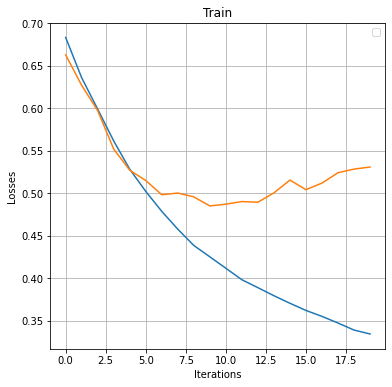

In [137]:
fig, ax = plt.subplots(figsize=(6, 6))
plt.title('Train')
plt.xlabel('Iterations')
plt.ylabel('Losses')
plt.grid()
ax.plot(losses)
ax.plot(losses_eval)
ax.legend()
plt.show()

In [138]:
losses[-1]

0.33413625305349176

In [139]:
losses_eval[-1]

0.53072190284729

In [140]:
f1s[-1]

tensor(0.8709, device='cuda:0')

In [141]:
f1s_eval[-1]

tensor(0.7601, device='cuda:0')

In [145]:
val_sentences['predicted']  = predict_word_symbol(model, val_iterator)

In [146]:
# TP
val_sentences[(val_sentences['tone'] == 1) & (val_sentences['predicted'] == 1)]['clean_text'].to_list()[:10]

['здоровски погуляли по магазинам с USER пингвины',
 'прикольно когда к тебе в бар приходит девушка выпить кофе на мин 1 15 а в итоге зависает у тебя в баре на хороших часа полтора',
 'USER не умирай еще тебе предстоит вечер',
 'rt USER юмор красота требует жертв придумай смешную подпись к картинке URL',
 'давайте уж побыстрее 12 декабря объявляйте выходным днем и переносите на пятницу 13 буду строить планы',
 'USER холодно очень и паскаль делает мне страдай d',
 'время сна я утомилась дико завтра сложный день 6 5 часов мне на восстановление сил всем доброй ночи',
 'ник вернется в сериал полиция гавайев счастьерадость ну правильно а то закончили на самом интересном',
 'USER смешно ему и плюс мне масса нужна в спорте немного я как бить буду если сил нету крч диета для идиотов',
 'USER иногда хочется тебя ретвитить но функция недоступна']

In [147]:
# FN
val_sentences[(val_sentences['tone'] == 1) & (val_sentences['predicted'] == 0)]['clean_text'].to_list()[:10]

['USER ну у меня времени много могу поиграть в шерлока но лучше скажи',
 'я только недавно хотела зимы теперь хочу лета а у лета я буду просить зимы',
 'поздравили любимого хореографа она была в восторге обожаем ее',
 'USER ну я пока еще с тюленем не танцевала',
 'USER USER другим не стыдно другим все равно',
 'блин аж н як забути цього не можу да не хочу боже так мило',
 'USER сломался он не знаю от чего но когда на него звонишь он говорит тебе бай бай так я теперь чика со старым телефоном',
 'i am training my english большой привет москве и санкт петербургу в and nyc',
 'USER на словах ты лев толстой а на деле хуй простой кароче нахуй послан окончательно терпила все видели что ты зассал',
 '9летняя девочка называет меня киса и чешет бороду приходится мурчать']

In [148]:
# FP
val_sentences[(val_sentences['tone'] == 0) & (val_sentences['predicted'] == 1)]['clean_text'].to_list()[:10]

['USER это дааа куда хочешь поступить',
 'USER ну я всегда говорил что я тп',
 'кто нибудь зайдите вк USER USER USER',
 'rt USER епт так ты баба нет кто тебе сказал такую глупость у меня есть пипирка URL',
 'что то много людей сейчас болеют выздоравливайте зайки',
 'USER каждый одинок по своему',
 'не знаю на сколько сегодня в универ а все говорят разное время',
 'помню как под эту песню я пытался мутить с ксюшей прэй фо ми блять',
 'USER нас курсач еще только ждет на антиплагиате проверять курсовые будут',
 'во мне две половины разрывается между желанием рожать детей и желанием жрать лсд и нюхать кокс с 37сантиметрового члена']

TP: здесь результаты не особо изменились, все еще выводятся высказывания с положительным контекстом

FN: здесь результаты не особо изменились, скорее просто скоратились

FP: здесь появились высказывания, выражающие сомнения

#Эксперимент

In [149]:
vocab = Counter()

for text in tweets_data['text']:
    vocab.update(text.split())
print('всего уникальных токенов:', len(vocab))

всего уникальных токенов: 305559


In [150]:
filtered_vocab = set()

for word in vocab:
    if vocab[word] > 2:
        filtered_vocab.add(word)
print('уникальных токенов, втретившихся больше 2 раз:', len(filtered_vocab))

уникальных токенов, втретившихся больше 2 раз: 37585


In [151]:
symbol_vocab = Counter()

for text in tweets_data['text']:
    symbol_vocab.update(list(text))
print('всего уникальных символов:', len(symbol_vocab))

всего уникальных символов: 341


In [152]:
symbol2id = {'PAD':0}

for symbol in symbol_vocab:
    symbol2id[symbol] = len(symbol2id)

id2symbol = {i:symbol for symbol, i in symbol2id.items()}

In [153]:
class ExpDataset(Dataset):

    def __init__(self, dataset, word2id, symbol2id, DEVICE):
        self.dataset = dataset['text'].values
        self.word2id = word2id
        self.symbol2id = symbol2id
        self.length = dataset.shape[0]
        self.target = torch.Tensor(dataset['tone'].values)
        self.device = DEVICE

    def __len__(self): #это обязательный метод, он должен уметь считать длину датасета
        return self.length

    def __getitem__(self, index): #еще один обязательный метод. По индексу возвращает элемент выборки
        tokens = self.dataset[index].split() # токенизируем
        word_ids = torch.LongTensor([self.word2id[token] for token in tokens if token in self.word2id])
        symbols = list(self.dataset[index])
        symb_ids = torch.LongTensor([self.symbol2id[symbol] for symbol in symbols if symbol in self.symbol2id])
        y = [self.target[index]]
        return word_ids, symb_ids, y

    def collate_fn(self, batch): #этот метод можно реализовывать и отдельно,
    # он понадобится для DataLoader во время итерации по батчам
      word_ids, symb_ids, y = list(zip(*batch))
      padded_words = pad_sequence(word_ids, batch_first=True).to(self.device)
      padded_symbs = pad_sequence(symb_ids, batch_first=True).to(self.device)
      #мы хотим применять BCELoss, он будет брать на вход predicted размера batch_size x 1 (так как для каждого семпла модель будет отдавать одно число), target размера batch_size x 1
      y = torch.Tensor(y).to(self.device) # tuple ([1], [0], [1])  -> Tensor [[1.], [0.], [1.]] 
      return padded_words, padded_symbs, y

In [154]:
train_dataset = ExpDataset(train_sentences, word2id, symbol2id, DEVICE)
train_sampler = RandomSampler(train_dataset)
train_iterator = DataLoader(train_dataset, collate_fn = train_dataset.collate_fn, sampler=train_sampler, batch_size=1024)

In [155]:
val_dataset = ExpDataset(val_sentences, word2id, symbol2id, DEVICE)
val_sampler = SequentialSampler(val_dataset)
val_iterator = DataLoader(val_dataset, collate_fn = val_dataset.collate_fn, sampler=val_sampler, batch_size=1024)

In [156]:
model = WordSymbCNN(len(symbol2id), 2, len(word2id))
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss()  

# веса модели и значения лосса храним там же, где и все остальные тензоры
model = model.to(DEVICE)
criterion = criterion.to(DEVICE)

In [157]:
losses = []
losses_eval = []
f1s = []
f1s_eval = []

for i in range(10):
    print(f'\nstarting Epoch {i}')
    print('Training...')
    epoch_loss = train(model, train_iterator, optimizer, criterion)
    losses.append(epoch_loss)
    print('\nEvaluating on train...')
    f1_on_train,_ = evaluate(model, train_iterator, criterion)
    f1s.append(f1_on_train)
    print('\nEvaluating on test...')
    f1_on_test, epoch_loss_on_test = evaluate(model, val_iterator, criterion)
    losses_eval.append(epoch_loss_on_test)
    f1s_eval.append(f1_on_test)


starting Epoch 0
Training...
Train loss: 0.7708606459200382
Train loss: 0.7268111741904056
Train loss: 0.7081413316726685
Train loss: 0.6972635655260798
Train loss: 0.688353643530891

Evaluating on train...
Val loss: 0.7004862502217293, Val f1: 0.6857378482818604
Val loss: 0.6794380383058027, Val f1: 0.665271520614624
Val loss: 0.6727498316764832, Val f1: 0.6578764915466309
Val loss: 0.6690991787768122, Val f1: 0.6550553441047668
Val loss: 0.6673052708307902, Val f1: 0.6526967883110046

Evaluating on test...
Val loss: 1.3089630603790283, Val f1: 1.330315113067627
Val loss: 0.8746776580810547, Val f1: 0.8825599551200867
Val loss: 0.7895276308059692, Val f1: 0.7848194241523743
Val loss: 0.7519354053906032, Val f1: 0.7477174401283264
Val loss: 0.7301345202657912, Val f1: 0.725041389465332

starting Epoch 1
Training...
Train loss: 0.6782073266804218
Train loss: 0.6499359481262438
Train loss: 0.6342548167705536
Train loss: 0.6222556918414671
Train loss: 0.6116975297530493

Evaluating on tr

No handles with labels found to put in legend.


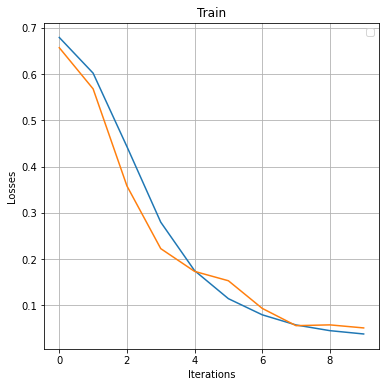

In [158]:
fig, ax = plt.subplots(figsize=(6, 6))
plt.title('Train')
plt.xlabel('Iterations')
plt.ylabel('Losses')
plt.grid()
ax.plot(losses)
ax.plot(losses_eval)
ax.legend()
plt.show()

In [159]:
losses[-1]

0.038379818222231486

In [160]:
losses_eval[-1]

0.05145123563706875

In [161]:
f1s[-1]

tensor(0.9861, device='cuda:0')

In [162]:
f1s_eval[-1]

tensor(0.9867, device='cuda:0')

In [164]:
val_sentences['predicted']  = predict_word_symbol(model, val_iterator)

In [165]:
# TP
val_sentences[(val_sentences['tone'] == 1) & (val_sentences['predicted'] == 1)]['clean_text'].to_list()[:10]

['здоровски погуляли по магазинам с USER пингвины',
 'прикольно когда к тебе в бар приходит девушка выпить кофе на мин 1 15 а в итоге зависает у тебя в баре на хороших часа полтора',
 'USER не умирай еще тебе предстоит вечер',
 'rt USER юмор красота требует жертв придумай смешную подпись к картинке URL',
 'давайте уж побыстрее 12 декабря объявляйте выходным днем и переносите на пятницу 13 буду строить планы',
 'USER холодно очень и паскаль делает мне страдай d',
 'время сна я утомилась дико завтра сложный день 6 5 часов мне на восстановление сил всем доброй ночи',
 'ник вернется в сериал полиция гавайев счастьерадость ну правильно а то закончили на самом интересном',
 'USER ну у меня времени много могу поиграть в шерлока но лучше скажи',
 'USER смешно ему и плюс мне масса нужна в спорте немного я как бить буду если сил нету крч диета для идиотов']

In [166]:
# FN
val_sentences[(val_sentences['tone'] == 1) & (val_sentences['predicted'] == 0)]['clean_text'].to_list()[:10]

['USER я тебя хоть трахну если попросишь d',
 'сегодня катерины в честь этого сделала себе роллов вообще в последнее время ем столько японской еды что скоро стану девочкой из анимэ',
 'скачала приложение simi и вот что он мне выдал пидорас такой d URL',
 'everything is made in china выступят в петербургском клубе da da URL']

In [167]:
# FP
val_sentences[(val_sentences['tone'] == 0) & (val_sentences['predicted'] == 1)]['clean_text'].to_list()[:10]

['школьная дискотека дает о себе знать синяк на коленке несгинающаяся шея и дождик в волосах',
 'USER очень жестка я сегодня хотел пойти но мне мама не разрешила хныык',
 'USER с както печально а что рисовать любишь',
 'USER USER USER USER USER USER USER и тебя с начинающим 3',
 'rt USER после проведения плазмолифтинга лица процесс омоложения с каждым месяцем усиливается URL',
 'USER та я тож если чесн как дела',
 'USER обычный белый белый с розовым и белый в шоколаде с',
 'USER что случилось не плааач дорогая',
 'USER и хорошо что все в порядке с',
 'USER USER USER USER это лишь ваше субъективное мнение']

TP: результаты почти не поменялись

FN: результаты сильно поменялись, видимо из-за 10-ти эпох

FP: результаты почти не поменялись